# Fishing Basics

This Notebook will walk through the very basic steps of how to load up data, set up the rotation profile and start extracting spectra.

## Get the Data

For this we will use the CS (3-2) emission in TW Hya, originally published in [Teague et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...864..133T). The emission is already clearly detected, but acts as a good starting point. You can download the data from [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/LO2QZM), making sure to place it in the directory where this notebook is.

## Load the Data

Loading the data is as simple as firing up `GoFish` and passing it the path of the fits cube to `imagecube`.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from gofish import imagecube

In [2]:
cube = imagecube('TWHya_CS_32.fits', clip=5.0)

You can use the `clip` argument here to trim down your image cube to a field of view which may speed up calculations.

## Coordinate System

We can deproject from a pixel position, $(x_{\rm pix},\, y_{\rm pix})$, to a disk-frame coordinate, $(r,\,\theta)$. These transforms are done through the `imagecube.disk_coords` function which takes geometrical properties of the disk and returns the disk coordinates.

For TW Hya we know that `i=5.0` and `PA=152.0` (both in degrees), so we can return the $(r,\,\theta)$ values for each pixel. We also assume the source is centered in the image such that `x0=0.0` and `y0=0.0`.

In [3]:
rvals, tvals, _ = cube.disk_coords(x0=0.0, y0=0.0, inc=5.0, PA=152.0)

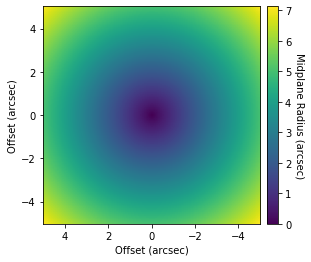

In [4]:
fig, ax = plt.subplots()
im = ax.imshow(rvals, origin='lower', extent=cube.extent, vmin=0.0)
cb = plt.colorbar(im, pad=0.02)
ax.set_xlabel('Offset (arcsec)')
ax.set_ylabel('Offset (arcsec)')
cb.set_label('Midplane Radius (arcsec)', rotation=270, labelpad=13)

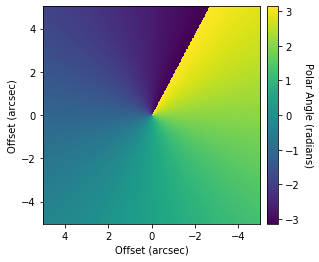

In [5]:
fig, ax = plt.subplots()
im = ax.imshow(tvals, origin='lower', extent=cube.extent)
cb = plt.colorbar(im, pad=0.02)
ax.set_xlabel('Offset (arcsec)')
ax.set_ylabel('Offset (arcsec)')
cb.set_label('Polar Angle (radians)', rotation=270, labelpad=13)

The polar angle, $\theta$, in is radians, and runs from $-\pi$ to $\pi$ in an eastward direction with $\theta = 0$ aligning with the red-shifted major axis of the disk. Note that this is _not_ the same as the position angle, particualrly when the disk is highly inclined.

You'll notice that when calling `disk_coords` we left space for three returned parameters. The third is $z$, the height above the midplane. By default, we assume that the disk is a razor-thin 2D disk. However, with the high spatial resolution afford by ALMA, it is now possible to resolve the vertical structure of the disk as well (see [Rosenfeld et al. 2013](https://ui.adsabs.harvard.edu/abs/2013ApJ...774...16R) for a nice demonstration of this for HD 163296).

For this, we assume that the emission surface is described via,

$$
z(r) = z_0 \times \left( \frac{r}{1^{\prime\prime}} \right)^{\psi} + z_1 \times \left( \frac{r}{1^{\prime\prime}} \right)^{\varphi}
$$

where the second term acts as a 'correction' term in order to account for the drop in emission surface expected due to the drop in gas surface density at large radii. `disk_coords` also accepts the parameters `z0, psi, z1, phi` to describe the emission height. If we take `psi=1.0`, we recover a conical disk, while `psi > 1.0` gives a flared disk surface.

As an example, we increase the inclination to make the changes due to the height more noticable.

In [6]:
rvals, tvals, zvals = cube.disk_coords(inc=50.0, PA=152.0, z0=0.3, psi=1.0)

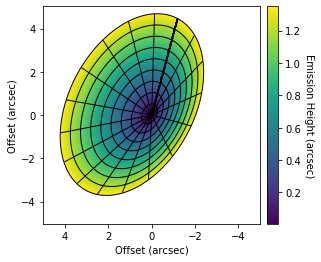

In [7]:
fig, ax = plt.subplots()
im = ax.imshow(np.where(rvals <= 4.5, zvals, np.nan), origin='lower', extent=cube.extent)
ax.contour(cube.xaxis, cube.yaxis, rvals, np.arange(0.5, 5.0, 0.5), linewidths=1.0, colors='k')
ax.contour(cube.xaxis, cube.yaxis, np.where(rvals <= 4.5, tvals, np.nan),
           np.linspace(-np.pi, np.pi, 18)[:-1], linewidths=1.0, linestyles='-', colors='k')
cb = plt.colorbar(im, pad=0.02)
ax.set_xlabel('Offset (arcsec)')
ax.set_ylabel('Offset (arcsec)')
cb.set_label('Emission Height (arcsec)', rotation=270, labelpad=13)

Note that in the above we've done some clipping to the arrays to make it look neater, although the arrays will span the entire field of view of the cube.

We can also assume the disk is rotated in the opposite direction by flipping the sign of the inclination.

In [8]:
rvals, tvals, zvals = cube.disk_coords(inc=-50.0, PA=152.0, z0=0.3, psi=1.0)

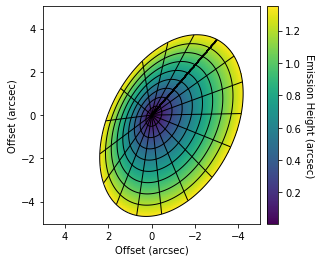

In [9]:
fig, ax = plt.subplots()
im = ax.imshow(np.where(rvals <= 4.5, zvals, np.nan), origin='lower', extent=cube.extent)
ax.contour(cube.xaxis, cube.yaxis, rvals, np.arange(0.5, 5.0, 0.5), linewidths=1.0, colors='k')
ax.contour(cube.xaxis, cube.yaxis, np.where(rvals <= 4.5, tvals, np.nan),
           np.linspace(-np.pi, np.pi, 18)[:-1], linewidths=1.0, linestyles='-', colors='k')
cb = plt.colorbar(im, pad=0.02)
ax.set_xlabel('Offset (arcsec)')
ax.set_ylabel('Offset (arcsec)')
cb.set_label('Emission Height (arcsec)', rotation=270, labelpad=13)

## Extracing a Disk Averaged Spectrum

Now that we know how to deproject the data, we can use this to map a Keplerian velocity field onto the disk and calculated the projected line of sight velocity, $v_0$, given by,

$$
v_0(r,\,\theta) = \sqrt{\frac{GM_{\rm star}r^2}{(r^2 + z^2)^{3/2}}} \, \cos (\theta) \, \sin (i),
$$

where we are expected to know $M_{\rm star}$ ($0.88~M_{\rm sun}$ for TW Hya), and the distance to the source ($59.5~{\rm pc}$).

To apply this we use the `averaged_spectrum` function, which is provided the geometrical properties of the disk to calculate $v_0$, before applying these shifts to concentric annuli of the data before combining them, weighted by the area of each annulus. We must also tell it what radial range to consider through the `r_min` and `r_max` parameters, both given in arcseconds.

In [10]:
x, y, dy = cube.average_spectrum(r_min=0.0, r_max=1.0, inc=5.0,
                                 PA=152., mstar=0.88, dist=59.5)

Notice the warning above, ``WARNING: Setting `r_min = cube.dpix` for safety.``. This is because we get a singularity at $r = 0$. If you really want to push in as close to the disk center as possible, try `r_min=1e-4`, but be warned, beam convolution effects limit the accuracy of this method in regions closer in than a beam FWHM.

Plotting the data gives a nice spectrum:

(1840.0, 3840.0)

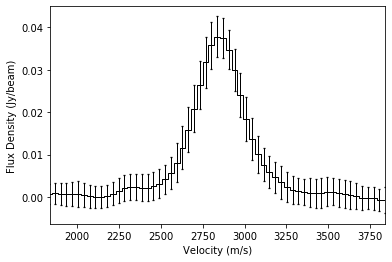

In [11]:
fig, ax = plt.subplots()
ax.errorbar(x, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='k', lw=1.0)
ax.step(x, y, where='mid', color='k', lw=1.0)
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Flux Density (Jy/beam)')
ax.set_xlim(1.84e3, 3.84e3)

Note also that by default `dy` is the standard deviation of the samples in the velocity bin (calculated by calling for the standard deviation of the bin with `scipy.stats.binned_statistics`), rather than the uncertainty on the flux density. This is because the binned data is not strictly independent owing to both small spectral and spatial correlations in the data.

Assuming that the data is indeed uncorrelated (not a toally unreasonable assumption), the uncertainty on the flux density can be estimated through

\begin{equation}
\delta y \approx \sigma_{\rm bin} \, \sqrt{\frac{\Delta V_{\rm chan} }{N_{\rm spectra} \,\Delta V_{\rm bin}}},
\end{equation}

where $N_{\rm spectra}$ is the number of spatially independent spectra used in each bin.

By using `assumed_correlated=False` in the call, we can return an estimate of the uncertainty of the flux density.

(1840.0, 3840.0)

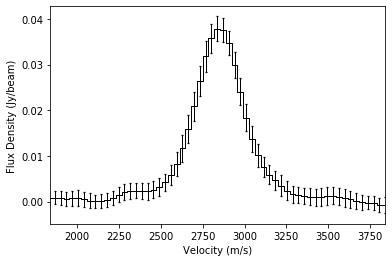

In [12]:
x, y, dy = cube.average_spectrum(r_min=0.0, r_max=1.0, inc=5.0,
                                 PA=152., mstar=0.88, dist=59.5,
                                 assume_correlated=False)

fig, ax = plt.subplots()
ax.errorbar(x, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='k', lw=1.0)
ax.step(x, y, where='mid', color='k', lw=1.0)
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Flux Density (Jy/beam)')
ax.set_xlim(1.84e3, 3.84e3)

This you can see is a slightly smaller value. For a higher resolution cube, the number of independent spectra will increase and thus the uncertainty on the flux density will decrease.

Because we end up sampling the line profile at a much higher rate thanks to the Doppler shift of the lines around the azimuth (see the discussion in [Teague et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...868..113T/)), we can resample at a higher rate. This is done through the `resample` parameter. By default this is `resample=1`, so returns the velocity axis attached to the cube.

If the argument is an `int`, then we super-sample by that factor, while if it is a `float`, then that is the channel spacing. For example:

(2540.0, 3140.0)

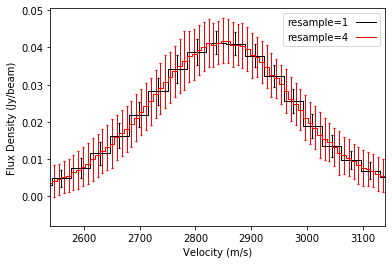

In [13]:
fig, ax = plt.subplots()

# Integeter
x, y, dy = cube.average_spectrum(r_min=0.5, r_max=1.0, inc=5.0, PA=152.,
                                 mstar=0.88, dist=59.5, dr_bin=0.1, resample=1,
                                 assume_correlated=False)
ax.errorbar(x, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='k', lw=1.0)
ax.step(x, y, where='mid', color='k', lw=1.0, label='resample=1')

# Float
x, y, dy = cube.average_spectrum(r_min=0.5, r_max=1.0, inc=5.0, PA=152.,
                                 mstar=0.88, dist=59.5, dr_bin=0.1, resample=4,
                                 assume_correlated=False)
ax.errorbar(x, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='r', lw=1.0)
ax.step(x, y, where='mid', color='r', lw=1.0, label='resample=4')

ax.legend(loc=1, markerfirst=False)
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Flux Density (Jy/beam)')
ax.set_xlim(2.54e3, 3.14e3)

Similarlaly, we can use down-sample the velocity axis if we want to improve the SNR of the detection.

(2340.0, 3340.0)

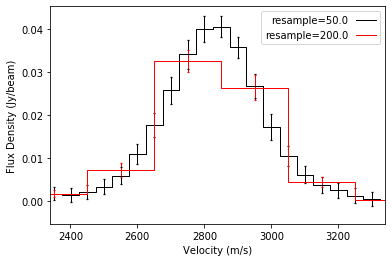

In [14]:
fig, ax = plt.subplots()

# Integeter
x, y, dy = cube.average_spectrum(r_min=0.5, r_max=1.0, inc=5.0, PA=152.,
                                 mstar=0.88, dist=59.5, dr_bin=0.1, resample=50.0,
                                 assume_correlated=False)
ax.errorbar(x, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='k', lw=1.0)
ax.step(x, y, where='mid', color='k', lw=1.0, label='resample=50.0')

# Float
x, y, dy = cube.average_spectrum(r_min=0.5, r_max=1.0, inc=5.0, PA=152.,
                                 mstar=0.88, dist=59.5, dr_bin=0.1, resample=200.0,
                                 assume_correlated=False)
ax.errorbar(x, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='r', lw=1.0)
ax.step(x, y, where='mid', color='r', lw=1.0, label='resample=200.0')

ax.legend(loc=1, markerfirst=False)
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Flux Density (Jy/beam)')
ax.set_xlim(2.34e3, 3.34e3)

____

**Quick Aside:** By binning the data to lower spectral resolutions you are actually losing information, even though it may appear to improve things. If you know that your line profile is Gaussian, you'll get the best results when fitting a Gaussian line when you have the highest spectral sampling. See, for example [Lenz & Ayres (1992)](https://ui.adsabs.harvard.edu/abs/1992PASP..104.1104L/).

____

Using the argument `unit='K'`, we can also return this in units of Kelvin, using the Rayleigh-Jeans approximation. And note it is exactly that, an approximation, and is a very poor conversion at sub-mm wavelengths, so use with caution! It does, however, offer a quick way to compare spectra _of the same frequency_, but imaged at different beam sizes.

## Extracted a Disk Integrated Spectrum

In a very similar fashion we can extract a disk integrated spectrum, returning a spectrum in units of Jansky. Again we provide it the inner and outer radii to integrate over.

(1840.0, 3840.0)

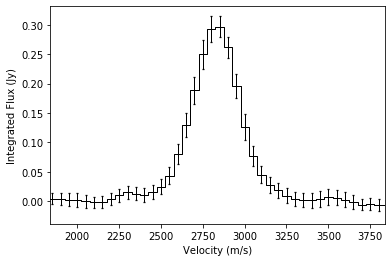

In [15]:
fig, ax = plt.subplots()
x, y, dy = cube.integrated_spectrum(r_min=0.5, r_max=1.0, inc=5.0, PA=152.,
                                    mstar=0.88, dist=59.5, dr_bin=0.1, resample=50.0)
ax.errorbar(x, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='k', lw=1.0)
ax.step(x, y, where='mid', color='k', lw=1.0)
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Integrated Flux (Jy)')
ax.set_xlim(1.84e3, 3.84e3)

## Radial Profiles

For well detected sources, you can also imaging wanting to plot radial profiles of their emission. Most typically people would plot the radial profile of the total integrated intensity, showing ${\rm Jy\,beam^{-1}\,km\,s^{-1}}$ as a function of radius, or the peak flux density, ${\rm Jy\,beam^{-1}}$, or the brightness temperature, ${\rm K}$, as a function of radius.

Most of the time this can be readily achieved by making moment maps (shameless plug for [`bettermoments`](https://github.com/richteague/bettermoments) to make such moment maps) and creating the radial profiles. However, even for bright sources, in the outer disk this approach is limited to what can be detected on a _per pixel_ basis. Shifting and stacking the spectra and give a significant improvement in the outer disk.

The easiest way to get a profile is to use the `radial_profile` function. As with the `averaged_spectrum` or `integrated_spectrum` you want to specify the source geometry. In addition, you can (should!) provide radial bin edges or centers (not both) and the unit you want. The allowed `unit` values are:

- ``'Jy m/s'``: Integrated spectrum in Janskys.
- ``'K m/s'``: Integrated spectrum in Kelvin using the full Planck conversion.
- ``'Jy'``: Peak of the integrated spectrum.
- ``'Jy/beam'``: Peak of the averaged spectrum.
- ``'K'``: Peak of the averaged spectrum in Kelvin using the full Planck conversion.

Text(0, 0.5, 'Peak Flux Density (Jy/beam)')

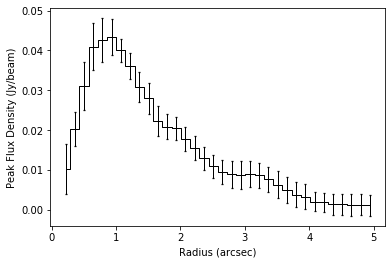

In [16]:
# Calculate the peak flux density as a function of radius.
x, y, dy = cube.radial_profile(inc=5., PA=152., mstar=0.88, dist=59.5, unit='Jy/beam')

# Plot
fig, ax = plt.subplots()
ax.errorbar(x, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='k', lw=1.0)
ax.step(x, y, where='mid', color='k', lw=1.0)
ax.set_xlabel('Radius (arcsec)')
ax.set_ylabel('Peak Flux Density (Jy/beam)')


For the integrated quantities, these are integrated over the _whole_ spectrum. You might want to apply your own clipping thresholds or integration ranges. If this is the case you can return an array of all the spectra using the `radial_specrta` function which takes the same values. Note this time `unit` can only be `'Jy'`, `'Jy/beam'` or `'K'`. 

In [17]:
# Get the array of spectra.
rvals, spectra = cube.radial_spectra(inc=5., PA=152., mstar=0.88, dist=59.5, unit='Jy/beam')

Here `rvals` is the array of bin centers used for the profile while `spectra` is of shape `(M, 3, N)` where `M` is the number of radial samples and `N` is the number of velocity samples. The second (index 1) axis is split over velocity, flux density and uncertainty.

In [18]:
print(rvals.shape, cube.velax.shape, spectra.shape)

(34,) (92,) (34, 3, 92)


A nice way to plot all these spectra is as follows which nicely demonstrates how the lines get weaker in the outer disk but also narrower.

(1840.0, 3840.0)

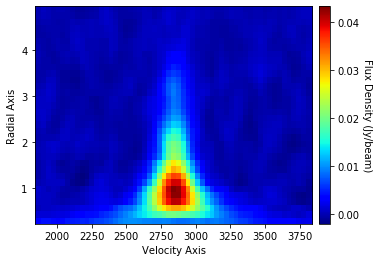

In [19]:
fig, ax = plt.subplots()
im = ax.imshow(spectra[:, 1], origin='lower', cmap='jet', aspect='auto',
               extent=[cube.velax[0], cube.velax[-1], rvals[0], rvals[-1]])
cb = plt.colorbar(im, pad=0.02)
cb.set_label('Flux Density (Jy/beam)', rotation=270, labelpad=13)
ax.set_xlabel('Velocity Axis')
ax.set_ylabel('Radial Axis')
ax.set_xlim(1.84e3, 3.84e3)